In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd

import random

import gc

%matplotlib inline

# 获取数据

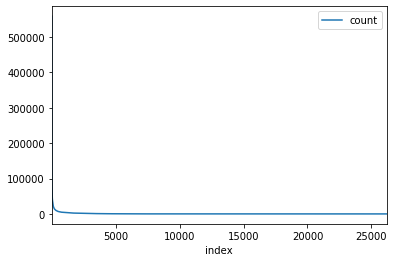

In [7]:
view_data = pd.read_csv("../viewData/view_data.csv")
anchor_list = pd.read_csv("../viewData/anchor_list.csv")
anchor_list = anchor_list.reset_index()
anchor_list['index'] = anchor_list['index'] + 1
anchor_list.plot(x='index', y='count')

# 删除出现频率过低的主播

In [9]:
frequent_anchor = anchor_list[anchor_list['count']>=10]

# 定义live_uid到index和index到live_uid的映射

In [10]:
index2uid = dict([(i, uid) for i, uid in zip(frequent_anchor['index'], frequent_anchor['live_uid'])])

uid2index = dict([(uid, i) for uid, i in zip(frequent_anchor['live_uid'], frequent_anchor['index'])])

# 将观看数据处理成Iterable[Iterable[Int]]的格式

In [13]:
view_data['index'] = view_data['live_uid'].map(uid2index)
data = {}
for uid, index in view_data[['uid', 'index']].dropna().values:
    if uid not in data:
        data[uid] = []
    data[uid].append(int(index))

In [22]:
# 随机打散，丢弃顺序信息
for v in data.values():
    random.shuffle(v)

# 采样

In [24]:
V = len(index2uid)

sampling_table = keras.preprocessing.sequence.make_sampling_table(V + 1)

In [31]:
def my_skipgrams(data, vocabulary_size,
              window_size=4, negative_samples=1., shuffle=True,
              categorical=False, sampling_table=None, seed=None):
    """
    data: List[List[Int]]
    vocabulary_size: number of all anchors
    negative_samples: number of negative samples / number of positive samples
    shuffle: whether to shuffle the return value
    categorical: whether to use one-hot label or binary label
    sampling_table: whether to use a sampling table to down sample frequent anchors and over sample infrequent ones
    seed: whether to use a fixed random seed
    returns: a list of instance pairs and a list of labels
    """
    couples = []
    labels = []
    for sequence in data:
        for i, wi in enumerate(sequence):
            if not wi:
                continue
            if sampling_table is not None:
                if sampling_table[wi] < random.random():
                    continue

            window_start = max(0, i - window_size)
            window_end = min(len(sequence), i + window_size + 1)
            for j in range(window_start, window_end):
                if j != i:
                    wj = sequence[j]
                    if not wj:
                        continue
                    couples.append([wi, wj])
                    if categorical:
                        labels.append([0, 1])
                    else:
                        labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)],
                     random.randint(1, vocabulary_size - 1)]
                    for i in range(num_negative_samples)]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)

    return couples, labels

In [29]:
view_data

,uid,live_uid,index
0,159876050,724698357,7471.0
1,735586379,724698357,7471.0
2,735586379,724698357,7471.0
3,108339673,724698357,7471.0
4,108339673,724698357,7471.0
...,...,...,...
18928319,722748450,14237047,NaN
18928320,99570557,733632108,8719.0
18928321,134628369,733632108,8719.0
18928322,735200625,735587024,4197.0


In [41]:
couples, labels = my_skipgrams(data.values(), V, sampling_table=sampling_table)

In [77]:
to_save = pd.DataFrame()

In [78]:
to_save['target'] = [x[0] for x in couples]

In [79]:
to_save['context'] = [x[1] for x in couples]
to_save['label'] = labels

In [102]:
to_save.set_index("target").to_csv('train.csv')

# 定义模型

In [20]:
def item2vecModel(vocab_size, embedding_dim):
    target = keras.layers.Input(shape=(1,), name='target')
    context = keras.layers.Input(shape=(1,), name='context')
    shared_embedding = keras.layers.Embedding(vocab_size, embedding_dim, input_length=1, name='shared_embedding')
    embedding_target = shared_embedding(target)
    embedding_context = shared_embedding(context)
    merged_vector = keras.layers.dot([embedding_target, embedding_context], axes=-1)
    reshaped_vector = keras.layers.Reshape((1,), input_shape=(1,1))(merged_vector)
    prediction = keras.layers.Dense(1, input_shape=(1,), activation='sigmoid')(reshaped_vector)
    model = keras.models.Model(inputs=[target, context], outputs=prediction)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model